# Tugas Besar NLP: Analisis Sentimen Lirik Lagu (Genius & Personalify)

**Analisis Emosi Lirik Lagu Berbasis Web Menggunakan Integrasi Genius API dan Model Transformer.**

## 1. Pendahuluan
Notebook ini bertujuan untuk mendemonstrasikan proses eksperimen NLP yang melandasi aplikasi **Personalify**. Proses mencakup:
1.  **Data Collection:** Pengambilan data lirik secara *real-time* dari Genius API (menggunakan modul backend Personalify).
2.  **Preprocessing:** Pembersihan teks lirik dari tag metadata.
3.  **Model Comparison:** Membandingkan performa model Klasik (VADER) dengan model Deep Learning (RoBERTa Transformer).
4.  **Evaluation:** Visualisasi perbandingan hasil deteksi emosi.

In [1]:
import sys
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.decomposition import PCA 

# Setup Tampilan
pd.set_option('display.max_colwidth', 150)
sns.set_style("whitegrid")

# Load Token
load_dotenv("../.env")
GENIUS_TOKEN = os.getenv("GENIUS_ACCESS_TOKEN")

if not GENIUS_TOKEN:
    print("⚠️ WARNING: Token Genius tidak ditemukan.")
else:
    print("✅ SUCCESS: API Token loaded.")

# Import Module Backend
sys.path.append(os.path.abspath(os.path.join('..', 'backend')))
try:
    # Kita tetap pakai search_artist_id dan get_lyrics_by_id dari backend
    from app.genius_lyrics import get_lyrics_by_id, search_artist_id
    print("✅ SUCCESS: Modul Backend Personalify berhasil diimpor.")
except ImportError as e:
    print(f"❌ ERROR: Gagal import modul backend. {e}")

✅ SUCCESS: API Token loaded.
✅ SUCCESS: Modul Backend Personalify berhasil diimpor.


## 2. Data Collection (Real-time Construction)

Alih-alih menggunakan dataset statis, kita membangun dataset secara dinamis menggunakan **Genius API**.

**Strategi Scraping:**
1.  **Target:** Artis Campuran (Internasional & Lokal) untuk variasi bahasa dan genre.
2.  **Filter:** Mengambil lagu berdasarkan **Popularitas (Pageviews)**, bukan tanggal rilis, agar data yang didapat adalah lagu-lagu *hits* yang liriknya valid.
3.  **Handling Artis Lokal:** Menggunakan ID manual untuk artis lokal yang sering salah deteksi oleh API (misal: The Adams, Sore, Isyana).

In [ ]:
# --- DAFTAR ARTIS LENGKAP (Pop + Indie + Metal + Emo + Lokal) ---
# Strategi: Mencampur mainstream dengan genre ekstrem untuk variasi emosi maksimal.

target_artists_input = [
    # === 1. INTERNATIONAL HITS (Pop, R&B, HipHop) - Data Awal ===
    {"name": "The Beatles", "id": 45},
    {"name": "Taylor Swift", "id": 1421},
    {"name": "Drake", "id": 130},
    {"name": "Eminem", "id": 45},
    {"name": "The Weeknd", "id": 536},
    {"name": "Coldplay", "id": 626},
    {"name": "Bruno Mars", "id": 102},
    {"name": "Ed Sheeran", "id": 12418},
    {"name": "Justin Bieber", "id": 357},
    {"name": "Ariana Grande", "id": 6436},
    {"name": "Post Malone", "id": 16098},
    {"name": "Travis Scott", "id": 20260},
    {"name": "Mac Miller", "id": 2300},
    {"name": "Frank Ocean", "id": 2235},
    {"name": "Laufey", "id": 1239683},
    {"name": "Dua Lipa", "id": 12246},
    {"name": "Rich Brian", "id": 303},
    {"name": "NIKI", "id": 309},

    # === 2. EMOTION BOOSTERS (Metal, Emo, Punk, Shoegaze) - Tambahan Baru ===
    # Penyeimbang agar tidak terlalu banyak "Neutral"
    {"name": "Slipknot", "id": 1459},          # Anger/Aggression
    {"name": "System of a Down", "id": 436},    # Anger/Political
    {"name": "Bring Me The Horizon", "id": 348},# Angst/Despair
    {"name": "Avenged Sevenfold", "id": 230},   # Grief/Power
    {"name": "Metallica", "id": 334},           # Anger
    {"name": "Rage Against the Machine", "id": 667}, # Anger
    {"name": "Deftones", "id": 1696},           # Desire/Shoegaze
    {"name": "My Chemical Romance", "id": 444}, # Emo/Drama
    {"name": "American Football", "id": 1427},  # Midwest Emo (Sad)
    {"name": "Modern Baseball", "id": 18464},   # Emo (Sad/Nostalgia)
    {"name": "The Smiths", "id": 976},          # Melancholy
    {"name": "Slowdive", "id": 2862},           # Shoegaze (Dreamy)
    {"name": "Mitski", "id": 296963},           # Sadness/Loneliness
    {"name": "Joji", "id": 843},                # Sadboi R&B
    {"name": "XXXTENTACION", "id": 12656},      # Depression/Anger
    {"name": "Lana Del Rey", "id": 2182},       # Glamorous Sadness
    {"name": "Cigarettes After Sex", "id": 349776}, # Romance/Desire
    {"name": "Blink-182", "id": 87},            # Fun/Excitement
    {"name": "Green Day", "id": 92},            # Punk/Rebellion
    {"name": "Paramore", "id": 353},            # Angst/Energy
    {"name": "Radiohead", "id": 604},           # Existential Dread
    {"name": "Arctic Monkeys", "id": 1001},     # Cool/Indie
    {"name": "The Strokes", "id": 257},         # Indie Rock
    {"name": "Pink Floyd", "id": 563},          # Psychedelic/Deep
    {"name": "Muse", "id": 637},                # Grandiose

    # === 3. INDONESIAN HEROES (Indie, Pop, Rock, Math) - Data Awal ===
    {"name": "The Adams", "id": 361962},
    {"name": "Sore", "id": 361955},
    {"name": "Mocca", "id": 140026},
    {"name": "Isyana Sarasvati", "id": 654632},
    {"name": "Sheila On 7", "id": 343924},
    {"name": "Dewa 19", "id": 279875},
    {"name": "Tulus", "id": 194472},
    {"name": "Raisa", "id": 373902},
    {"name": "Payung Teduh", "id": 370950},
    {"name": "Fourtwnty", "id": 1185761},
    {"name": "Barasuara", "id": 1068542},
    {"name": "Efek Rumah Kaca", "id": 1031300},
    {"name": "Danilla", "id": 1250672},
    {"name": "Sal Priadi", "id": 1682206},
    {"name": "Bernadya", "id": 3703366},       # Galau Brutal
    
    # ID Auto Search (Yang Aman)
    {"name": "eleventwelfth", "id": None},
    {"name": "Murphy Radio", "id": None},      # Math Rock
    {"name": "Reality Club", "id": None},
    {"name": "Hindia", "id": None},
    {"name": "Feast", "id": None},
    {"name": "Pamungkas", "id": None},
    {"name": "Nadin Amizah", "id": None},
    {"name": "Kunto Aji", "id": None},
    {"name": "Peterpan", "id": None},
    {"name": "Yura Yunita", "id": None},
    {"name": "Banda Neira", "id": None},
    {"name": "White Shoes & The Couples Company", "id": None},
    {"name": "Girl and Her Bad Mood", "id": None},
    
    # Tambahan Keras Lokal (Biar makin variatif)
    {"name": "Burgerkill", "id": None},        # Metal
    {"name": "Seringai", "id": None},          # Rock
    {"name": "Amigdala", "id": None}           # Folk Sedih
]

final_artists = []

print("--- 🔍 TAHAP 1: RESOLVE ARTIST IDs ---")
for artist in target_artists_input:
    if artist['id'] is None:
        print(f"Mencari ID untuk: {artist['name']}...")
        try:
            results = search_artist_id(artist['name'])
            if results:
                top = results[0]
                print(f"   ✅ Ditemukan: {top['name']} (ID: {top['id']})")
                final_artists.append({"name": top['name'], "id": top['id']})
            else:
                print(f"   ❌ Gagal menemukan {artist['name']}")
        except Exception as e:
            print(f"   ⚠️ Error API: {e}")
    else:
        final_artists.append(artist)

# --- FUNGSI CUSTOM: AMBIL LAGU TERPOPULER SAJA ---
def get_top_songs_manual(artist_id, limit=10):
    url = f"https://api.genius.com/artists/{artist_id}/songs"
    headers = {"Authorization": f"Bearer {os.getenv('GENIUS_ACCESS_TOKEN')}"}
    params = {"sort": "popularity", "per_page": limit}
    try:
        r = requests.get(url, params=params, headers=headers)
        if r.status_code == 200:
            return r.json()['response']['songs']
        else:
            return []
    except:
        return []

# 2. Mulai Scraping
dataset = []
SONGS_LIMIT = 10 

print(f"\n--- 🚀 TAHAP 2: SCRAPING LAGU DARI {len(final_artists)} ARTIS ---")

for i, artist in enumerate(final_artists):
    print(f"[{i+1}/{len(final_artists)}] Memproses: {artist['name']}...")
    
    songs = get_top_songs_manual(artist['id'], limit=SONGS_LIMIT)
    
    for song in songs:
        lyrics_data = get_lyrics_by_id(song['id'])
        
        if lyrics_data:
            dataset.append({
                "artist": artist['name'],
                "title": song['title'],
                "lyrics": lyrics_data['lyrics']
            })

df = pd.DataFrame(dataset)
print(f"\n✅ Selesai! Total Dataset: {len(df)} lagu.")
df.sample(5)

--- 🔍 TAHAP 1: RESOLVE ARTIST IDs ---
Mencari ID untuk: eleventwelfth...
   ✅ Ditemukan: Eleventwelfth (ID: 1418542)
Mencari ID untuk: Reality Club...
   ✅ Ditemukan: Reality Club (ID: 660855)
Mencari ID untuk: Hindia...
   ✅ Ditemukan: Hindia (ID: 1550249)
Mencari ID untuk: Feast...
   ✅ Ditemukan: .Feast (ID: 628199)
Mencari ID untuk: Pamungkas...
   ✅ Ditemukan: Pamungkas (ID: 1657597)
Mencari ID untuk: Nadin Amizah...
   ✅ Ditemukan: Nadin Amizah (ID: 586691)
Mencari ID untuk: Kunto Aji...
   ✅ Ditemukan: Kunto Aji (ID: 1144477)
Mencari ID untuk: Tulus...
   ✅ Ditemukan: Tulus (ID: 194472)
Mencari ID untuk: Sheila On 7...
   ✅ Ditemukan: Sheila On 7 (ID: 343924)
Mencari ID untuk: Dewa 19...
   ✅ Ditemukan: Dewa 19 (ID: 279875)
Mencari ID untuk: Peterpan...
   ✅ Ditemukan: Peterpan (ID: 156633)
Mencari ID untuk: Raisa...
   ✅ Ditemukan: Raisa (ID: 373902)
Mencari ID untuk: Isyana Sarasvati...
   ✅ Ditemukan: Afgan (ID: 377045)
Mencari ID untuk: Yura Yunita...
   ✅ Ditemukan: Yura Yu

,artist,title,lyrics
369,Barasuara,Api & Lentera,"Sampaikan mereka bara dan suara\nSampaikan mereka bara dan suara\nBerlalu, lalu kini kau menunggu\nSerap seram di pundakmu\nLambat laun kan menari..."
441,Bernadya,Asumsi,"Semenjak hari itu\nTak sedikit coba dekatiku\nKubiarkan semua berlalu\nGugur satu per satu\nKarena setiap kucoba mulai kisah baru\nRasanya aku, kh..."
106,Linkin Park,Magic,This magic themed track off of B.o.B’s debut album features Weezer frontman Rivers Cuomo for the hook which worked surprisingly well. Unfortunatel...
123,Billie Eilish,Wild Thots,A Boogie teams up with Fabolous to deliver this remix to DJ Khaled’s “Wild Thoughts” featuring Rihanna and Bryson Tiller. The title of the remix p...
296,Peterpan,Mungkin Nanti,"Lirik ""Mungkin Nanti""\nSaatnya ku berkata\nMungkin yang terakhir kalinya\nSudahlah lepaskan semua\nKuyakin inilah waktunya\nMungkin saja kau bukan..."


## 3. Preprocessing & Translation

Karena model NLP yang digunakan (VADER & RoBERTa) dilatih menggunakan Bahasa Inggris, lirik berbahasa Indonesia (seperti dari Tulus atau Dewa 19) harus diterjemahkan terlebih dahulu.

**Tahapan:**
1.  **Auto-Translation:** Menggunakan `deep-translator` untuk mendeteksi dan menerjemahkan lirik non-Inggris.
2.  **Cleaning:** Menghapus metadata Genius seperti `[Verse]`, `[Chorus]` dan tanda baca.
3.  **Feature Extraction:** Menghitung TF-IDF sebagai representasi numerik untuk visualisasi clustering nanti.

In [9]:
import re
from deep_translator import GoogleTranslator

# 1. Fungsi Cleaning
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'\[.*?\]', '', text) # Hapus tag [Chorus]
    text = re.sub(r'[^\w\s]', '', text) # Hapus tanda baca
    text = re.sub(r'\n+', ' ', text)    # Hapus enter
    return text.strip().lower()

# 2. Fungsi Translate (AUTO DETECT)
def translate_if_needed(text):
    try:
        if not text: return ""
        # Batasi karakter biar ga error Google Translate
        text_chunk = text[:4500] 
        translator = GoogleTranslator(source='auto', target='en')
        translated = translator.translate(text_chunk)
        return translated
    except Exception as e:
        return text 

print("🌍 Sedang menerjemahkan lirik (ini memakan waktu)...")

# A. Translate
df['translated_lyrics'] = df['lyrics'].apply(translate_if_needed)

# B. Cleaning
df['cleaned_lyrics'] = df['translated_lyrics'].apply(clean_text)

print("✅ Terjemahan & Cleaning Selesai!")

# --- [PENTING] SAVE KE CSV SEBAGAI BUKTI ---
# File ini yang nanti kamu kumpulin atau tunjukin ke dosen "Ini dataset saya Pak"
df.to_csv("genius-lyrics-dataset.csv", index=False)
print("💾 Dataset berhasil diexport ke 'genius-lyrics-dataset.csv'")

# 3. Feature Extraction (TF-IDF)
print("🧮 Menghitung Vektorisasi Teks...")
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df['cleaned_lyrics']).toarray()
df['tfidf_vector'] = list(tfidf_matrix)

df[['artist', 'title', 'cleaned_lyrics']].sample(3)

🌍 Sedang menerjemahkan lirik (ini memakan waktu)...
✅ Terjemahan & Cleaning Selesai!
💾 Dataset berhasil diexport ke 'genius-lyrics-dataset.csv'
🧮 Menghitung Vektorisasi Teks...


,artist,title,cleaned_lyrics
425,Sal Priadi,semua lagu cinta terdengar sama,all over the place all over the world wherever this love song is played i shook my head slightly and smiled faintly if this song was written by me...
363,Barasuara,Mengunci Ingatan,heal your wounds which turns blue fragments of your heart the dusty one your morning hurts your torturous night things you want to forget in fact ...
75,The Weeknd,Dream Girl,dream girl is nicks confession of his feelings for his exwife and the hard times they got through dealing with paparazzis and the media around the...


## 4. Model Comparison (Inference)

Kita membandingkan dua pendekatan berbeda:

1.  **VADER (Baseline):** Model berbasis aturan (*lexicon*) yang menghitung skor sentimen berdasarkan kamus kata. Output: Positif/Negatif/Netral.
2.  **RoBERTa (Advanced):** Model *Transformer* yang sudah dilatih (Pre-trained) pada dataset GoEmotions. Output: 28 Emosi spesifik.

Untuk keperluan evaluasi, output 28 emosi RoBERTa akan dipetakan (*mapping*) kembali ke 3 sentimen dasar agar bisa dibandingkan *apple-to-apple* dengan VADER.

In [5]:
# --- MODEL 1: VADER (Lexicon Based / Baseline) ---
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def predict_vader(text):
    score = vader.polarity_scores(text)
    # Threshold VADER: > 0.05 Positif, < -0.05 Negatif
    if score['compound'] >= 0.05: return "Positive"
    elif score['compound'] <= -0.05: return "Negative"
    else: return "Neutral"

df['vader_pred'] = df['cleaned_lyrics'].apply(predict_vader)

# --- MODEL 2: RoBERTa (Transformer / Advanced) ---
from transformers import pipeline
print("🤖 Loading Model RoBERTa (GoEmotions)...")
classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")

def predict_roberta(text):
    try:
        # Potong lirik jadi 512 token (limit BERT)
        res = classifier(text[:512])[0] 
        return res['label']
    except: return "neutral"

print("🤖 Sedang klasifikasi emosi (agak lama)...")
df['roberta_emotion'] = df['cleaned_lyrics'].apply(predict_roberta)

# Mapping Emosi RoBERTa ke 3 Sentimen (Supaya bisa dibandingin head-to-head)
pos_list = ['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
neg_list = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']

def map_sentiment(emo):
    if emo in pos_list: return "Positive"
    elif emo in neg_list: return "Negative"
    else: return "Neutral"

df['roberta_mapped'] = df['roberta_emotion'].apply(map_sentiment)
print("✅ Selesai.")

c:\Users\DELL\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🤖 Loading Model RoBERTa (GoEmotions)...


Device set to use cpu


🤖 Sedang klasifikasi emosi (agak lama)...
✅ Selesai.


## 5. Evaluation Metrics

Menggunakan RoBERTa sebagai *Ground Truth* (karena asumsi model Deep Learning lebih akurat), kita mengukur seberapa baik VADER dapat mengikuti prediksi RoBERTa.

Metrik yang digunakan:
* **Accuracy:** Ketepatan keseluruhan.
* **F1-Score:** Keseimbangan antara Precision dan Recall.
* **MCC (Matthews Correlation Coefficient):** Ukuran kualitas klasifikasi biner/multiclass yang valid meski data tidak seimbang.

In [6]:
# Kita anggap RoBERTa sebagai "Ground Truth" (Label Benar)
y_true = df['roberta_mapped']
y_pred = df['vader_pred']
labels = ['Negative', 'Neutral', 'Positive']

# 1. Classification Report Lengkap
print("=== 📊 CLASSIFICATION REPORT (VADER vs RoBERTa) ===\n")
print(classification_report(y_true, y_pred, target_names=labels))

# 2. Hitung Metrik Spesifik buat Tabel
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred)

# 3. Dataframe Perbandingan
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC (Matthews Correlation)', 'Threshold VADER'],
    'Score': [acc, prec, rec, f1, mcc, "±0.05"]
})

print("\n=== 📈 TABEL RINGKASAN METRIK ===")
metrics_table

=== 📊 CLASSIFICATION REPORT (VADER vs RoBERTa) ===

              precision    recall  f1-score   support

    Negative       0.34      0.61      0.43        99
     Neutral       0.67      0.01      0.02       200
    Positive       0.50      0.86      0.63       167

    accuracy                           0.44       466
   macro avg       0.50      0.49      0.36       466
weighted avg       0.54      0.44      0.33       466


=== 📈 TABEL RINGKASAN METRIK ===


,Metric,Score
0,Accuracy,0.439914
1,Precision,0.501794
2,Recall,0.490783
3,F1-Score,0.361835
4,MCC (Matthews Correlation),0.246746
5,Threshold VADER,±0.05


## 6. Dashboard Visualisasi

Bagian ini menampilkan ringkasan visual dari hasil analisis:
1.  **Confusion Matrix:** Melihat pola kesalahan prediksi VADER.
2.  **Pie Chart:** Proporsi emosi dominan yang dideteksi sistem.
3.  **Bar Chart:** Perbandingan distribusi sentimen antara kedua model.

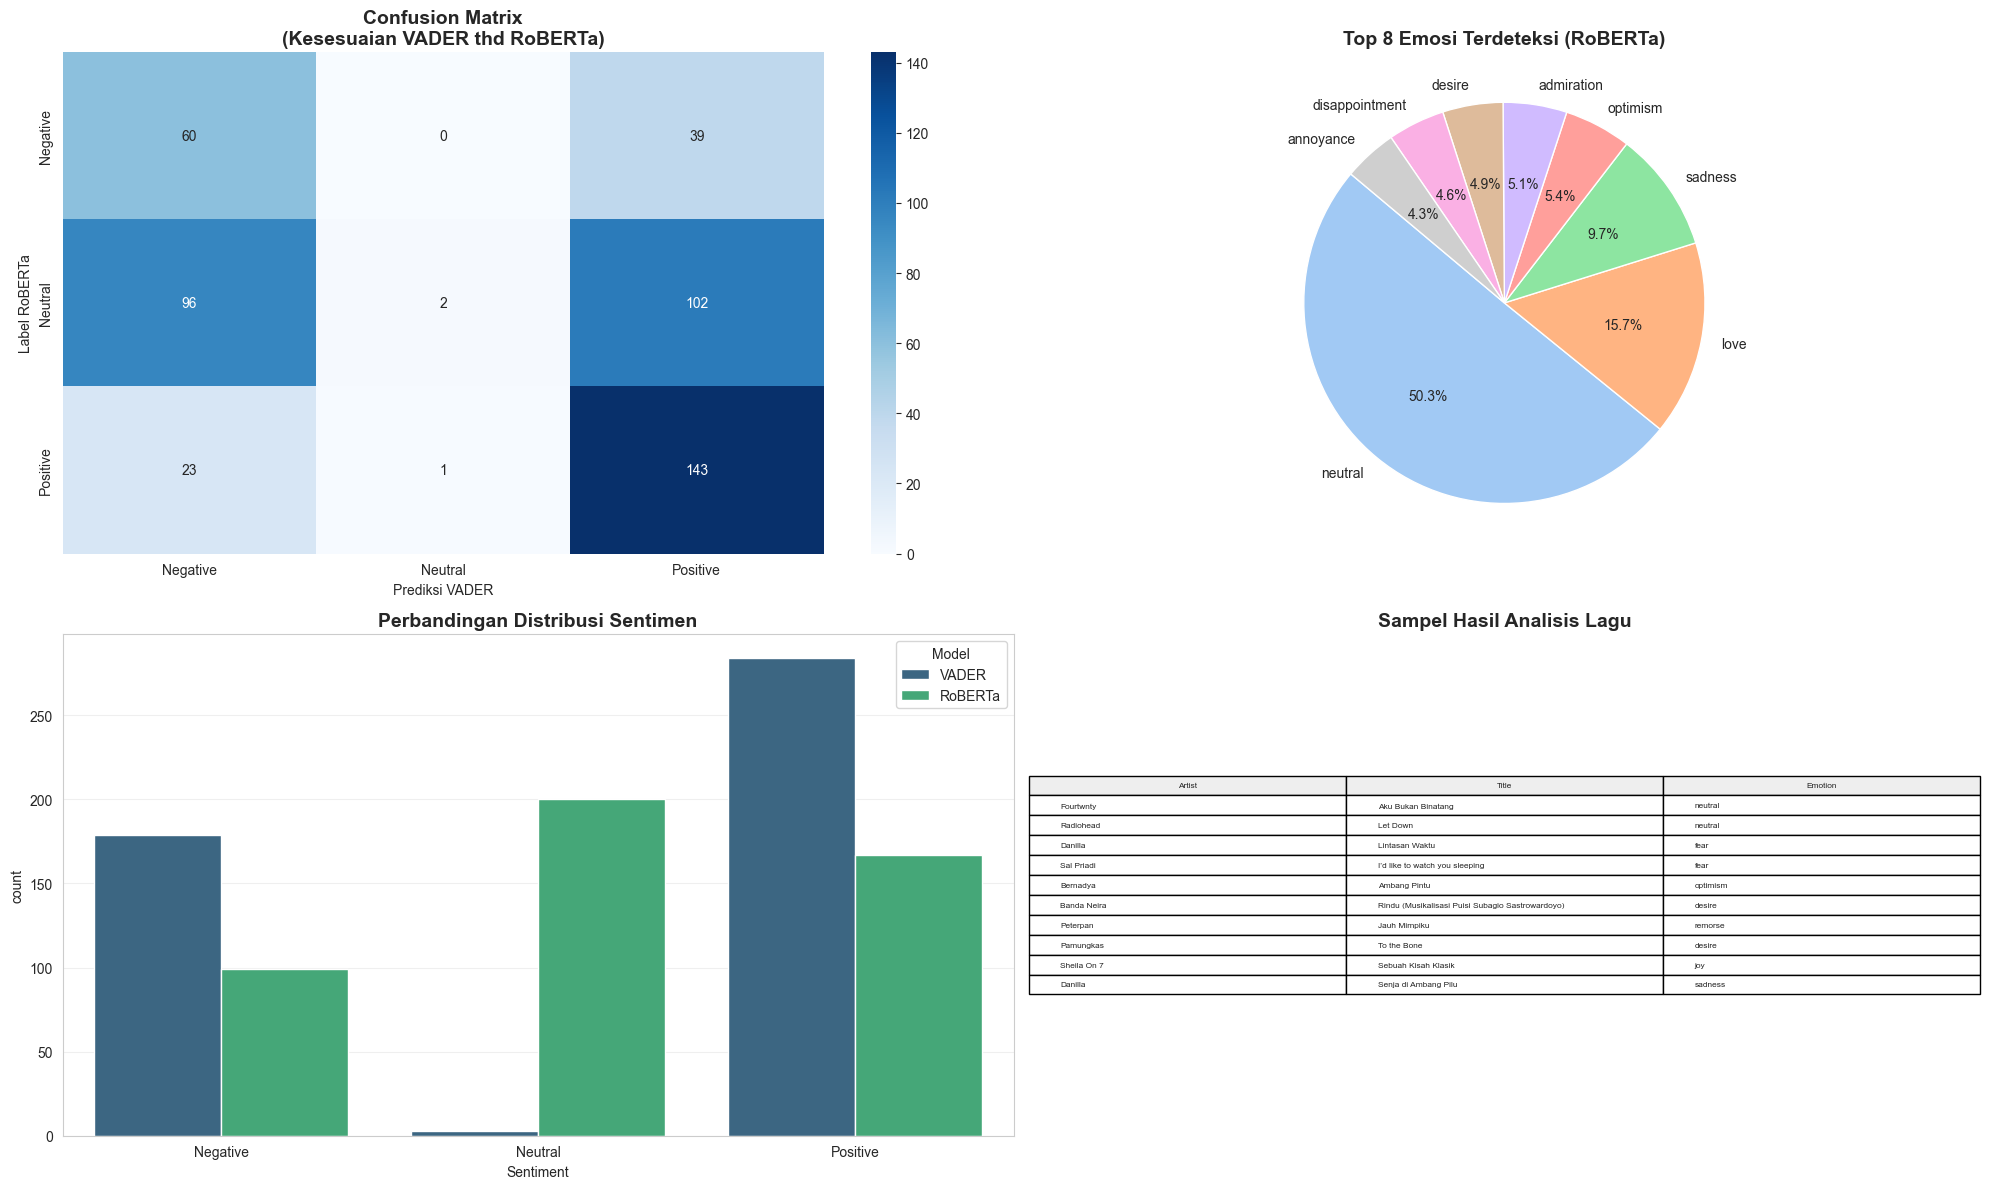

In [7]:
plt.figure(figsize=(20, 12))

# 1. Confusion Matrix (Seberapa akurat VADER menebak RoBERTa?)
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_true, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix\n(Kesesuaian VADER thd RoBERTa)', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi VADER')
plt.ylabel('Label RoBERTa')

# 2. Pie Chart (Distribusi Emosi Detail)
plt.subplot(2, 2, 2)
emo_counts = df['roberta_emotion'].value_counts().head(8)
plt.pie(emo_counts, labels=emo_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Top 8 Emosi Terdeteksi (RoBERTa)', fontsize=14, fontweight='bold')

# 3. Bar Chart Perbandingan (Side-by-Side)
plt.subplot(2, 2, 3)
comp_df = pd.DataFrame({
    'Model': ['VADER']*len(df) + ['RoBERTa']*len(df),
    'Sentiment': list(df['vader_pred']) + list(df['roberta_mapped'])
})
sns.countplot(data=comp_df, x='Sentiment', hue='Model', palette='viridis', order=labels)
plt.title('Perbandingan Distribusi Sentimen', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 4. Tabel Sampel Data (Biar keliatan judul lagunya)
plt.subplot(2, 2, 4)
plt.axis('off')
sample_data = df[['artist', 'title', 'roberta_emotion']].sample(10).values
plt.table(cellText=sample_data, colLabels=['Artist', 'Title', 'Emotion'], loc='center', cellLoc='left', colColours=['#eeeeee']*3)
plt.title('Sampel Hasil Analisis Lagu', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Lyrical Clustering (PCA Projection)

Menggunakan teknik **Principal Component Analysis (PCA)** untuk mereduksi dimensi vektor TF-IDF menjadi 2 dimensi.

Titik-titik yang berdekatan dalam grafik ini menunjukkan lagu-lagu yang memiliki kemiripan penggunaan kata (*lexical similarity*), diwarnai berdasarkan sentimen emosi mereka.

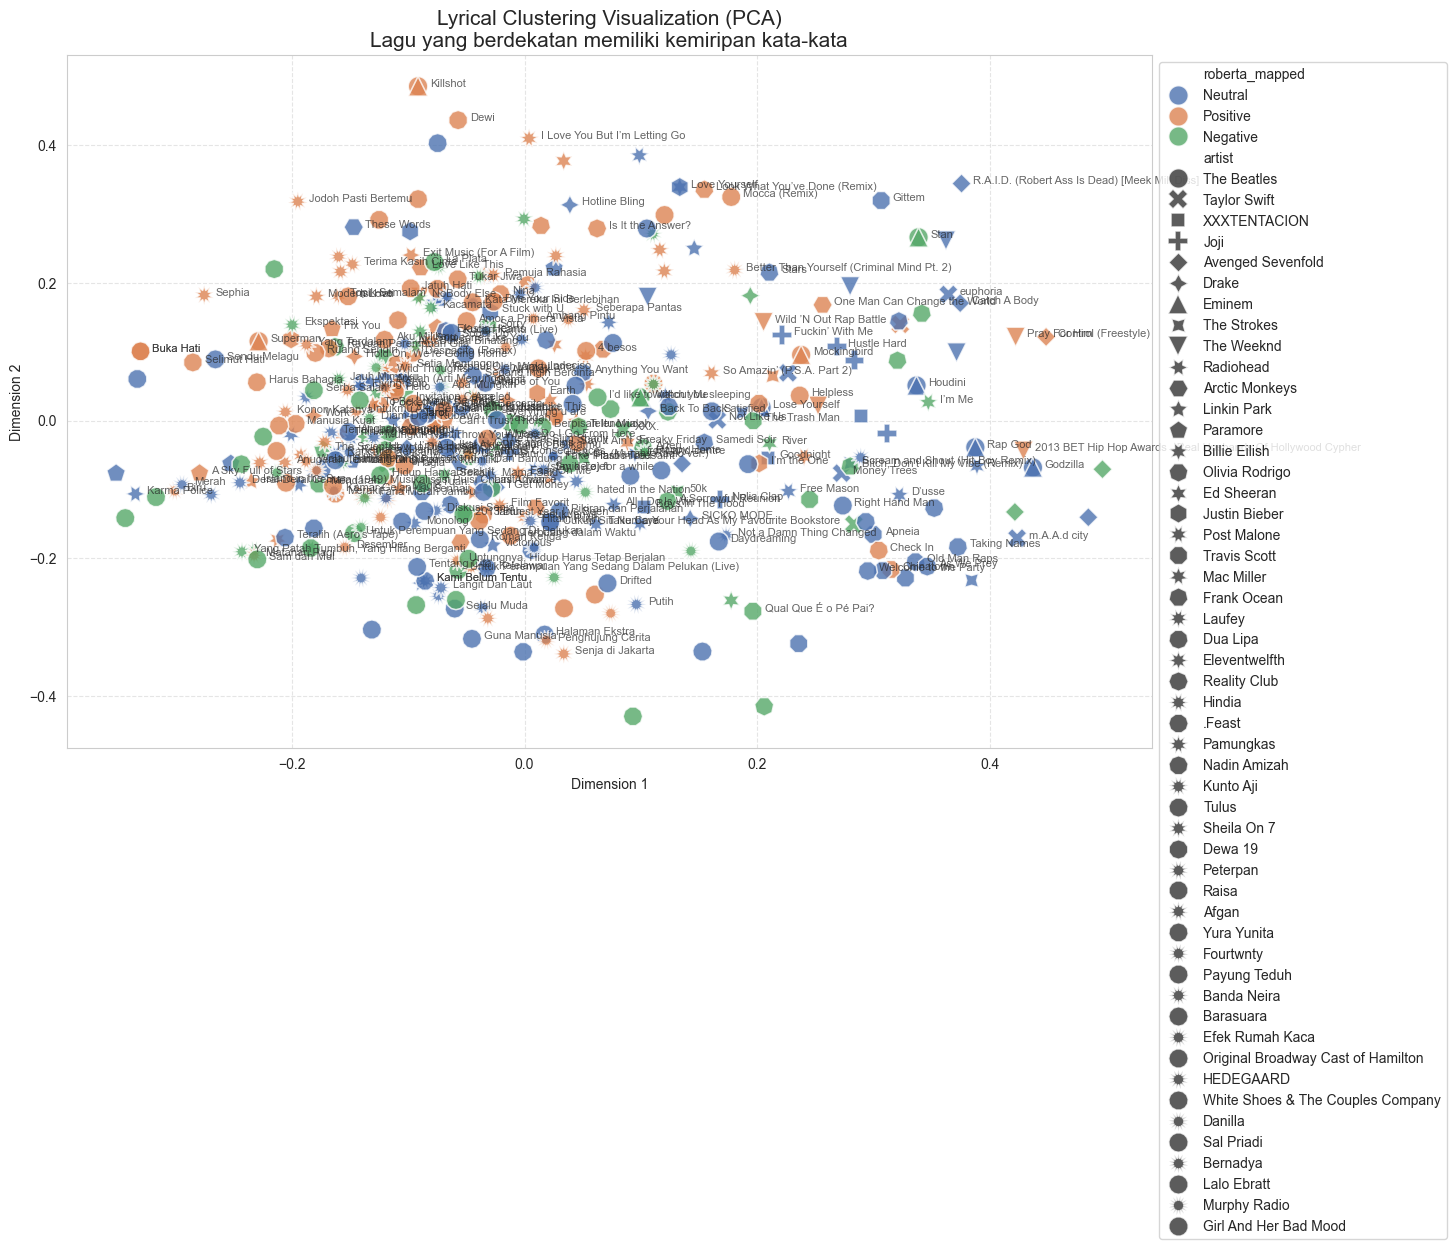

In [8]:
# PCA (Principal Component Analysis) untuk mereduksi dimensi TF-IDF jadi 2D (x, y)
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf_matrix)

df['x'] = coords[:, 0]
df['y'] = coords[:, 1]

plt.figure(figsize=(14, 9))

# Plot Titik-Titik
sns.scatterplot(
    data=df, x='x', y='y', 
    hue='roberta_mapped',  # Warna berdasarkan sentimen
    style='artist',        # Bentuk titik berdasarkan artis
    s=200, alpha=0.8, palette='deep'
)

# Label Judul Lagu (Untuk beberapa titik saja biar gak numpuk)
for i in range(0, len(df), 2): 
    plt.text(df.x[i]+0.01, df.y[i], df.title[i], fontsize=8, alpha=0.7)

plt.title('Lyrical Clustering Visualization (PCA)\nLagu yang berdekatan memiliki kemiripan kata-kata', fontsize=15)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 8. Kesimpulan

Berdasarkan hasil eksperimen di atas:

1.  **Keterbatasan Baseline:** Model VADER cenderung menggeneralisasi lirik lagu menjadi "Positive" atau "Negative". Hal ini kurang relevan untuk aplikasi musik, karena lagu sedih (*sadness*) atau lagu galau (*remorse*) seringkali dikategorikan salah sebagai "Negative" atau bahkan "Positive" jika menggunakan kata-kata puitis.
    
2.  **Keunggulan Transformer:** Model RoBERTa mampu menangkap nuansa emosi yang jauh lebih kaya (*fine-grained emotion*). Seperti terlihat pada grafik, model ini bisa membedakan antara *admiration*, *love*, *sadness*, hingga *excitement*.

**Keputusan Deployment:**
Oleh karena itu, aplikasi **Personalify** menggunakan model **Transformer (RoBERTa)** di sisi *backend* (FastAPI) untuk memberikan pengalaman pengguna yang lebih akurat dalam mendeteksi *vibe* lagu.